In [1]:
!python -V

Python 3.10.10


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
#!pip install seaborn

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

#### Import the data

In [7]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet

#### Show data

In [7]:
df_jan_22 = pd.read_parquet('yellow_tripdata_2022-01.parquet')

#Question 1: Number of columns in Jan 2022 Yellow Taxi Trip data

df_jan_22

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [9]:
df_jan_22['duration'] = df_jan_22.tpep_dropoff_datetime - df_jan_22.tpep_pickup_datetime
df_jan_22.duration = df_jan_22.duration.apply(lambda td: td.total_seconds() / 60)

In [8]:
df_jan_22.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,2.463931e+06,2.392428e+06,2.463931e+06,2.392428e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.392428e+06,2.392428e+06
mean,1.707819e+00,1.389453e+00,5.372751e+00,1.415507e+00,1.660768e+02,1.635807e+02,1.194449e+00,1.294648e+01,1.006710e+00,4.914539e-01,2.385696e+00,3.749773e-01,2.967234e-01,1.916937e+01,2.282322e+00,8.249935e-02
std,5.021375e-01,9.829686e-01,5.478714e+02,5.917573e+00,6.546806e+01,7.079016e+01,5.001778e-01,2.558149e+02,1.236226e+00,8.291560e-02,2.830698e+00,1.680538e+00,4.374741e-02,2.559641e+02,7.432040e-01,3.125554e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-4.800000e+02,-4.500000e+00,-5.000000e-01,-1.252200e+02,-3.140000e+01,-3.000000e-01,-4.803000e+02,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,1.000000e+00,1.040000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,7.200000e-01,0.000000e+00,3.000000e-01,1.130000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.740000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.469000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,1.000000e+00,3.130000e+00,1.000000e+00,2.340000e+02,2.360000e+02,1.000000e+00,1.400000e+01,2.500000e+00,5.000000e-01,3.000000e+00,0.000000e+00,3.000000e-01,2.002000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,9.000000e+00,3.061593e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.010923e+05,3.350000e+01,1.659000e+01,8.888800e+02,1.933000e+02,3.000000e-01,4.010956e+05,2.500000e+00,1.250000e+00


In [10]:
import numpy as np
#Question 2:  Standard deviation of the trips duration in Jan 2022 Yellow Taxi Trip data

std_deviation = np.std(df_jan_22['duration'])
std_deviation

46.445295712725304

In [11]:
#apply outliers, only duration trips between 1 to 60 min
df_jan_22 = df_jan_22[(df_jan_22.duration >= 1) & (df_jan_22.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_jan_22[categorical] = df_jan_22[categorical].astype(str)


/tmp/ipykernel_874517/4292844715.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jan_22[categorical] = df_jan_22[categorical].astype(str)


In [13]:
 df_jan_22

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,17.816667
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,8.400000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,8.966667
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,10.033333
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,37.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN,5.966667
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN,10.650000
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN,11.000000
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN,12.050000


In [14]:
#Question 3: Fraction of the records left after dropping the outliers
#The Original dataset has 2463931 rows vs 2421440 rows 

2421440/2463931

0.9827547930522406

In [1]:
#Question 4: Dimensionality after OHE
train_dicts = df_jan_22[categorical].to_dict(orient='records')

dv = DictVectorizer()

fm = dv.fit_transform(train_dicts) #feature matrix

# Convert the feature matrix to an array
fm_array = fm.toarray()

# Print the dimensionality of the feature matrix
dim = fm_array.shape
print("Dimensionality:", dim)

NameError: name 'df_jan_22' is not defined

In [12]:
train_dicts = df_jan_22[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_jan_22[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

6.986190837370544

/tmp/ipykernel_874517/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_874517/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


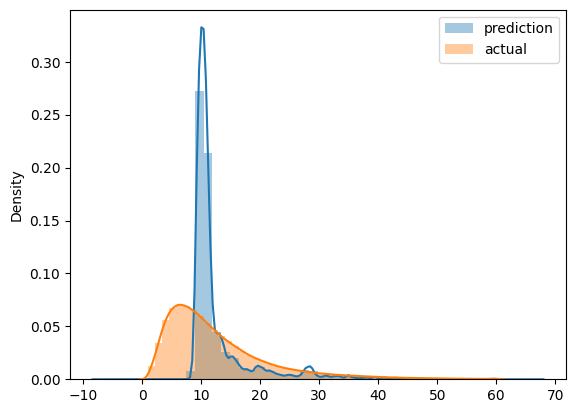

In [16]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [17]:
#prepare the data for training

def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [18]:
#Let’s evaluate our model on the unseen Yellow Taxi February 2022
df_train = read_dataframe('yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('yellow_tripdata_2022-02.parquet')

In [19]:
len(df_train), len(df_val)

(2421440, 2918187)

In [27]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [28]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.786409085078911

In [ ]:
with open('lin_reg_model.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)